# Group Assignment QF627

*Group Members:*
* Anna Germaine Lim
* Peng Cheng
* Zenith Tay
* Gregory Tan

# Prep Work

## Packages Used in This Workbook

In [62]:
## Data Download

import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime
import pandas_datareader as pdr

## For Visualisation

In [ ]:
### For Supervised learning

# Model specification

# linear models
from sklearn.linear_model import LinearRegression # Linear Regression
from sklearn.linear_model import ElasticNet # Elastic Net
from sklearn.linear_model import Lasso # LASSO

# oldies
from sklearn.svm import SVR # Support Vector Machine
from sklearn.neighbors import KNeighborsRegressor # K-Nearest Neighbor

# decision tree
from sklearn.tree import DecisionTreeRegressor# Decision Tree

# bagging
from sklearn.ensemble import RandomForestRegressor # Random Forest
from sklearn.ensemble import ExtraTreesRegressor # Extra Trees

# boosting
from sklearn.ensemble import GradientBoostingRegressor # Gradient Boosting Tree
from sklearn.ensemble import AdaBoostRegressor # Adaptive Boosting

# time-series
import statsmodels.tsa.arima.model as stats # ARIMA
from statsmodels.graphics.tsaplots import plot_acf

# Data split
from sklearn.model_selection import train_test_split

# feature engineering

from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import chi2

from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from matplotlib.ticker import MaxNLocator

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

## Functions

### Download of Data

In [63]:
start_date = "2006-11-01"
end_date = "2025-11-13"

In [64]:
def download_data (ticker: list[str] | str,
                   start_date = start_date, 
                   end_date = end_date,
                   close_only = False) -> pd.DataFrame:
    if close_only == False:
        data =\
        (
            yf.download(tickers = ticker,
                        start = start_date,
                        end = end_date)
        )
    else:
        data =\
        (
            yf.download(tickers = ticker,
                        start = start_date,
                        end = end_date)
                        ["Close"]
        )    

    return data

In [65]:
# preallocate empty array and assign slice by chrisaycock

def np_shift(arr, num, fill_value=np.nan):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

### Mean Reversion Strategies

In [66]:
def bollinger_band(price_data: pd.Series,
                            window: int = 14,
                                                ) -> pd.Series:

    price = price_data[price_col]

    std_dev_series =\
    (
        price
        .rolling(window = window)
        .std()
    )

    price_high =\
    (
        price + 2*std_dev_series
    )

    price_low =\
    (
        price - 2*std_dev_series
    )

    return price_high, price_low

### Momentum

In [67]:
## Moving Average

def generate_moving_avg(price_data: pd.Series,
                        window: int
                                              ) -> pd.Series:
    
    ma_series =\
    (
        pd.Series
        (   
            price_data
            .rolling(window = window)
            .mean(),

            name = 'MA' + str(window)
        )
    )

    return ma_series

In [68]:
## Exponential Moving Average

def generate_EMA(price_data: pd.Series, 
                    window: int
                            ) -> pd.Series:
    EMA = pd.Series(price_data
                    .ewm(span = window,
                         min_periods = window)
                    .mean(),
                    name = "EMA_" + str(window)
                    )
    return EMA

In [ ]:
## Generate Moving Avg Cross Signal

def generate_moving_avg_cross_signal(long_ma: pd.Series,
                                    short_ma: pd.Series) -> pd.Series:
    
    ## Sanity Check
    if len(long_ma) != len(short_ma):
        print('MA series lengths not equal, please check')
        return

    ## Return Signals
    else:

        moving_avg_cross_positions = np.where(short_ma > long_ma, 1.0, 0.0)
        moving_avg_cross_positions = np.where(short_ma < long_ma, -1.0 , moving_avg_cross_positions)

        moving_avg_cross_signals = np.where(moving_avg_cross_positions - np_shift(moving_avg_cross_positions,1) > 0, 1, 0)
        moving_avg_cross_signals = np.where(moving_avg_cross_positions - np_shift(moving_avg_cross_positions, 1) < 0, -1, moving_avg_cross_signals)

        buy_or_sell = pd.DataFrame({'MA_Cross_Signal':moving_avg_cross_signals, 'MA_Cross_Position': moving_avg_cross_positions},
                                   index = long_ma.index
                                   )

        return buy_or_sell

In [ ]:
## ROC

def generate_rate_of_change(price_data: pd.Series,
                            n: int
                            ) -> pd.Series:
    
    ROC = pd.Series(
                        (price_data - price_data.diff(n)) / price_data.diff(n),
                        name = 'ROC'+str(n),
                        # index = price_data.index
                    )
    
    return ROC

def generate_rate_of_change_signal(roc_data: pd.Series) -> pd.Series:

    roc_position = pd.Series(np.where(roc_data > 0, 1.0, 0.0), index=roc_data.index, name = 'ROC_Position')
    roc_signal = roc_position.diff()
    roc_signal.name = 'ROC_Signal'
    
    # roc_signal = roc_position - np_shift(roc_position, 1)


    # buy_or_sell = pd.DataFrame({'ROC_Position': roc_position, 'ROC_Signal': roc_signal},
    #                         #    index = roc_data.index
    #                            )

    return pd.concat([roc_position, roc_signal], axis=1)

In [ ]:
## RSI

def generate_RSI(series, period):
    
    delta = series.diff().dropna()
    
    u = delta * 0
    d = u.copy()
    
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    
    u[u.index[period - 1]] = np.mean( u[:period] ) # 
    
    u = u.drop(u.index[:(period - 1)
                      ]
              )
    
    d[d.index[period - 1]] = np.mean( d[:period] )
    
    d = d.drop(d.index[:(period - 1)
                      ]
              )
    
    rs = u.ewm(com = period - 1, adjust = False).mean() / \
         d.ewm(com = period - 1, adjust = False).mean()
    
    return 100 - 100 / (1 + rs)

def generate_rsi_signal(rsi_data: pd.Series) -> pd.Series:

    rsi_position = pd.Series(np.where(rsi_data > 50, 1.0, -1.0), 
                             index= rsi_data.index, 
                             name = 'rsi_position')
    
    rsi_signal = rsi_position.diff()
    rsi_signal.name = 'rsi_signal'
    
    # rsi_signal = rsi_position - np_shift(rsi_position, 1)


    # buy_or_sell = pd.DataFrame({'rsi_position': rsi_position, 'rsi_signal': rsi_signal},
    #                         #    index = rsi_data.index
    #                            )

    return pd.concat([rsi_position, rsi_signal], axis=1)

In [ ]:
def generate_force_index(data_price: pd.Series, data_vol: pd.Series, period: int) -> pd.Series:

    indicator = data_price.diff() * data_vol
    lag_indicator = indicator.ewm(span = period, adjust = False).mean()

    return lag_indicator

def generate_force_index_signal(data: pd.Series) -> pd.Series:

    position = pd.Series(np.where(data >= 0, 1.0, -1.0),
                        index = data.index,
                        name = 'FI_position'
                        )
    signal = position.diff()/2
    signal.name = 'FI_signal'

    return pd.concat([position, signal], axis = 1)

### Performance Metrics

In [76]:
## Annualised Sharpe

def annual_sharpe(returns):
    days = (returns.index[-1] - returns.index[0]).days
    
    return\
    (
        (
            (1+returns).prod()
            **(365/days) 
            - 1
        )
        /
        returns.std()
        /
        np.sqrt(252)
    )

In [77]:
## CAGR

def cagr(returns: pd.Series) -> float:
    days = (returns.index[-1] - returns.index[0]).days
    return ( (1 + returns).prod() )**(365/days) - 1   

In [78]:
### Max Drawdown

def max_drawdown(cumulative_returns):
    max_performance = cumulative_returns.cummax()
    dd = ((max_performance - cumulative_returns) / max_performance).max()
    return dd


### Longest Drawdown

def calculate_longest_drawdown(cumulative_returns):
    drawdown = cumulative_returns.cummax() - cumulative_returns
    period =\
    (
        np
        .diff(np
              .append(drawdown[drawdown == 0].index, 
                      drawdown.index[-1: ]
                    )
            )
    )
    return period.max() / np.timedelta64(1, "D")

In [79]:
def evaluate_returns(returns_series: pd.Series, to_print: bool = False):
    
    cum_returns_series = (1 + returns_series).cumprod()

    tot_returns = (1 + returns_series).prod() - 1
    CAGR = cagr(returns_series)
    Annualised_Sharpe = annual_sharpe(returns_series)
    Max_DD = max_drawdown(cum_returns_series)
    Longest_DD = calculate_longest_drawdown(cum_returns_series)

    if to_print == True:
      print('-- Summary of Returns -- \n',
            f'Total Returns: {tot_returns: .2%} \n',
            f'CAGR: {CAGR: .2%} \n',
            f'Annualised_Sharpe: {Annualised_Sharpe: .2%} \n',
            f'Max Drawdown: {Max_DD: .2%} \n',
            f'Longest Drawdown (Days): {Longest_DD}'            
            )

    return pd.Series([tot_returns, CAGR, Annualised_Sharpe, Max_DD, Longest_DD])

In [80]:
def generate_returns(price_data: pd.DataFrame,
                     price_col: 'str' = 'Close') -> pd.Series:
    
    returns_series = price_data[price_col].pct_change()
    cum_returns_series = (1 + returns_series).cumprod()

    tot_returns = float(cum_returns_series.iloc[-1].iloc[0])

    print('=== Summary of Returns === \n',
          f'Total Returns = {tot_returns: .2%}'
          )

    return tot_returns, returns_series, cum_returns_series

## Download Dataset

In [81]:
spy_data =\
(
    download_data("SPY", start_date, end_date)
)
spy_data

C:\Users\TanFamily4\AppData\Local\Temp\ipykernel_2260\1882972918.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf.download(tickers = ticker,
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2006-11-01,95.973602,96.990418,95.875427,96.927308,83005600
2006-11-02,95.917511,96.078796,95.622986,95.728169,60693100
2006-11-03,95.749214,96.345284,95.104062,96.261137,71346400
2006-11-06,96.829117,96.969365,96.036697,96.043716,63303300
2006-11-07,97.200813,97.460274,96.773048,96.913297,63318900
...,...,...,...,...,...
2025-11-06,670.309998,677.380005,668.719971,676.469971,85035300
2025-11-07,670.969971,671.080017,661.210022,667.909973,100592400


In [82]:
spy_data = \
    (
        spy_data
        .droplevel(
            level = 1,
            axis =1
        )
    )

# Part 1: Analysis and Strategy

Data Wrangling and Preparation

In [ ]:
train_pct = 0.75
train_test_split_index = int(train_pct*len(spy_data))
spy_train_data =\
    (
        spy_data
        .copy()
        .iloc[ : train_test_split_index]
    )

spy_test_data =\
    (
        spy_data
        .copy()
        .iloc[train_test_split_index : ]
    )

In [84]:
len(spy_train_data) + len(spy_test_data)

4788

In [ ]:
display(spy_train_data, spy_train_data)

Price,Close,High,Low,Open,Volume
Date,,,,,
2006-11-01,95.973602,96.990418,95.875427,96.927308,83005600
2006-11-02,95.917511,96.078796,95.622986,95.728169,60693100
2006-11-03,95.749214,96.345284,95.104062,96.261137,71346400
2006-11-06,96.829117,96.969365,96.036697,96.043716,63303300
2006-11-07,97.200813,97.460274,96.773048,96.913297,63318900
...,...,...,...,...,...
2021-02-02,357.220306,358.783831,352.323818,355.441466,64450700
2021-02-03,357.501221,359.233261,356.218584,358.053596,52427100
2021-02-04,361.564484,361.611284,357.613572,358.540435,47142600


## (1A) Momentum Trading Strategy

### Functions to Generate Positions and Signals

In [240]:
## Moving Average

def generate_moving_avg(price_data: pd.Series,
                        window: int
                                              ) -> pd.Series:
    
    ma_series =\
    (
        pd.Series
        (   
            price_data
            .rolling(window = window)
            .mean(),

            name = 'MA' + str(window)
        )
    )

    return ma_series

In [241]:
## Exponential Moving Average

def generate_EMA(price_data: pd.Series, 
                    window: int
                            ) -> pd.Series:
    EMA = pd.Series(price_data
                    .ewm(span = window,
                         min_periods = window)
                    .mean(),
                    name = "EMA_" + str(window)
                    )
    return EMA

In [242]:
def generate_moving_avg_cross_signal(long_ma: pd.Series,
                                    short_ma: pd.Series) -> pd.Series:
    
    ## Sanity Check
    if len(long_ma) != len(short_ma):
        print('MA series lengths not equal, please check')
        return

    ## Return Signals
    else:

        moving_avg_cross_positions = np.where(short_ma > long_ma, 1.0, 0.0)
        moving_avg_cross_positions = np.where(short_ma < long_ma, -1.0 , moving_avg_cross_positions)

        moving_avg_cross_signals = np.where(moving_avg_cross_positions - np_shift(moving_avg_cross_positions,1) > 0, 1, 0)
        moving_avg_cross_signals = np.where(moving_avg_cross_positions - np_shift(moving_avg_cross_positions, 1) < 0, -1, moving_avg_cross_signals)

        buy_or_sell = pd.DataFrame({'MA_Cross_Signal':moving_avg_cross_signals, 'MA_Cross_Position': moving_avg_cross_positions},
                                   index = long_ma.index
                                   )

        return buy_or_sell

In [243]:
## Rate of Change

def generate_rate_of_change(price_data: pd.Series,
                            n: int
                            ) -> pd.Series:
    
    ROC = pd.Series(
                        (price_data - price_data.diff(n)) / price_data.diff(n),
                        name = 'ROC'+str(n),
                        # index = price_data.index
                    )
    
    return ROC

In [244]:
def generate_rate_of_change_signal(roc_data: pd.Series) -> pd.Series:

    roc_position = pd.Series(np.where(roc_data > 0, 1.0, 0.0), index=roc_data.index, name = 'ROC_Position')
    roc_signal = roc_position.diff()
    roc_signal.name = 'ROC_Signal'
    
    # roc_signal = roc_position - np_shift(roc_position, 1)


    # buy_or_sell = pd.DataFrame({'ROC_Position': roc_position, 'ROC_Signal': roc_signal},
    #                         #    index = roc_data.index
    #                            )

    return pd.concat([roc_position, roc_signal], axis=1)

In [245]:
## RSI

def generate_RSI(series, period):
    
    delta = series.diff().dropna()
    
    u = delta * 0
    d = u.copy()
    
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    
    u[u.index[period - 1]] = np.mean( u[:period] ) # 
    
    u = u.drop(u.index[:(period - 1)
                      ]
              )
    
    d[d.index[period - 1]] = np.mean( d[:period] )
    
    d = d.drop(d.index[:(period - 1)
                      ]
              )
    
    rs = u.ewm(com = period - 1, adjust = False).mean() / \
         d.ewm(com = period - 1, adjust = False).mean()
    
    return 100 - 100 / (1 + rs)

In [246]:
def generate_rsi_signal(rsi_data: pd.Series) -> pd.Series:

    rsi_position = pd.Series(np.where(rsi_data > 50, 1.0, -1.0), 
                             index= rsi_data.index, 
                             name = 'rsi_position')
    
    rsi_signal = rsi_position.diff()
    rsi_signal.name = 'rsi_signal'
    
    # rsi_signal = rsi_position - np_shift(rsi_position, 1)


    # buy_or_sell = pd.DataFrame({'rsi_position': rsi_position, 'rsi_signal': rsi_signal},
    #                         #    index = rsi_data.index
    #                            )

    return pd.concat([rsi_position, rsi_signal], axis=1)

In [247]:
def generate_force_index(data_price: pd.Series, data_vol: pd.Series, period: int) -> pd.Series:

    indicator = data_price.diff() * data_vol
    lag_indicator = indicator.ewm(span = period, adjust = False).mean()

    return lag_indicator

In [248]:
def generate_force_index_signal(data: pd.Series) -> pd.Series:

    position = pd.Series(np.where(data >= 0, 1.0, -1.0),
                        index = data.index,
                        name = 'FI_position'
                        )
    signal = position.diff()/2
    signal.name = 'FI_signal'

    return pd.concat([position, signal], axis = 1)

### Functions to Generate Metrics

In [249]:
## Annualised Sharpe

def annual_sharpe(returns):
    days = (returns.index[-1] - returns.index[0]).days
    
    return\
    (
        (
            (1+returns).prod()
            **(365/days) 
            - 1
        )
        /
        returns.std()
        /
        np.sqrt(252)
    )

## CAGR

def cagr(returns: pd.Series) -> float:
    days = (returns.index[-1] - returns.index[0]).days
    return ( (1 + returns).prod() )**(365/days) - 1   

### Max Drawdown

def max_drawdown(cumulative_returns):
    max_performance = cumulative_returns.cummax()
    dd = ((max_performance - cumulative_returns) / max_performance).max()
    return dd

### Longest Drawdown

def calculate_longest_drawdown(cumulative_returns):
    drawdown = cumulative_returns.cummax() - cumulative_returns
    period =\
    (
        np
        .diff(np
              .append(drawdown[drawdown == 0].index, 
                      drawdown.index[-1: ]
                    )
            )
    )
    return period.max() / np.timedelta64(1, "D")

### Evaluate Returns in Totality

def evaluate_returns(returns_series: pd.Series, to_print: bool = False):
    
    cum_returns_series = (1 + returns_series).cumprod()

    tot_returns = (1 + returns_series).prod() - 1
    CAGR = cagr(returns_series)
    Annualised_Sharpe = annual_sharpe(returns_series)
    Max_DD = max_drawdown(cum_returns_series)
    Longest_DD = calculate_longest_drawdown(cum_returns_series)

    if to_print == True:
      print('-- Summary of Returns -- \n',
            f'Total Returns: {tot_returns: .2%} \n',
            f'CAGR: {CAGR: .2%} \n',
            f'Annualised_Sharpe: {Annualised_Sharpe: .2%} \n',
            f'Max Drawdown: {Max_DD: .2%} \n',
            f'Longest Drawdown (Days): {Longest_DD}'            
            )

    return pd.Series([tot_returns, CAGR, Annualised_Sharpe, Max_DD, Longest_DD])

### Download Dataset

In [250]:
train_proportion = 0.75

spy_data =\
(
    download_data('SPY',
                  start_date = '2006-11-01',
                  end_date = '2025-11-12')
    .droplevel(level = 1,
               axis = 1)
    [['Close', 'Volume']]
).resample('W-FRI').agg({'Close': 'last', 'Volume': 'sum'})

spy_train_data = spy_data[:int(train_proportion*len(spy_data))]

spy_data_close = spy_train_data['Close'].to_frame()
spy_data_returns = spy_train_data['Close'].pct_change().to_frame().rename(columns= {'Close': 'Returns'})

C:\Users\TanFamily4\AppData\Local\Temp\ipykernel_2260\1882972918.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf.download(tickers = ticker,
[*********************100%***********************]  1 of 1 completed


In [251]:
evaluate_returns(spy_data_returns['Returns'], to_print=True)

-- Summary of Returns -- 
 Total Returns:  279.10% 
 CAGR:  9.79% 
 Annualised_Sharpe:  23.57% 
 Max Drawdown:  54.61% 
 Longest Drawdown (Days): 1771.0


0       2.791023
1       0.097898
2       0.235731
3       0.546130
4    1771.000000
dtype: float64

### FI Train (No Luck)
FI Signals attempted to include volume to indicate strength of the turn. However for indication of trends, not very useful

In [252]:
time_periods = np.arange(10, 201, 10).tolist()

In [255]:
def generate_fi_Metrics(time_periods):

    Metrics = pd.DataFrame()

    for i in time_periods:

        data = spy_data_returns.copy()
        
        data[f'fi{i}'] = generate_force_index(spy_data['Close'], spy_data['Volume'], i)
        
        data = pd.concat([data, generate_force_index_signal(data[f'fi{i}'])], axis = 1)
        
        data['Strat_returns'] = data['Returns'] * data['FI_position'].shift(1)
        
        # print(f'===Data for ROC{i}===')
        strat_series = evaluate_returns(data['Strat_returns'])
        strat_series.name = f'FI{i}'
        
        Metrics = pd.concat([Metrics, strat_series], axis = 1)

    Metrics.index = ['Total Returns', 'CAGR', 'Annualised Sharpe', 'Max Drawdown', 'Longest Drawdown (Days)']
    return Metrics.T

In [256]:
generate_fi_Metrics(list(range(10,251,10))).sort_values(by = 'Annualised Sharpe', ascending=False)

,Total Returns,CAGR,Annualised Sharpe,Max Drawdown,Longest Drawdown (Days)
FI10,-0.374802,-0.032382,-0.077718,0.484255,4354.0
FI40,-0.551478,-0.054644,-0.131191,0.725768,4354.0
FI20,-0.552316,-0.054768,-0.131489,0.722404,4354.0
FI50,-0.572261,-0.057782,-0.138736,0.751453,4354.0
FI30,-0.586334,-0.059989,-0.144041,0.715840,4354.0
FI60,-0.601473,-0.062442,-0.149941,0.768427,4354.0
FI70,-0.601659,-0.062472,-0.150015,0.749207,4354.0
FI80,-0.669854,-0.074729,-0.179515,0.796984,4354.0
FI110,-0.672302,-0.075212,-0.180677,0.802883,4354.0
FI100,-0.673991,-0.075547,-0.181483,0.803711,4354.0


### ROC (No Luck)
ROC Signals Significantly Underperformed the Market

In [257]:
def generate_ROC_Metrics(time_periods):

    ROC_Metrics = pd.DataFrame()

    for i in time_periods:
        roc_data = spy_data_returns.copy()
        
        roc_data[f'ROC{i}'] = generate_rate_of_change(spy_data_close['Close'], i)
        roc_data = pd.concat([roc_data, generate_rate_of_change_signal(roc_data[f'ROC{i}'])], axis = 1)
        roc_data['Strat_returns'] = roc_data['Returns'] * roc_data['ROC_Position'].shift(1)
        
        # print(f'===Data for ROC{i}===')
        roc_series = evaluate_returns(roc_data['Strat_returns'])
        roc_series.name = f'ROC{i}'
        
        ROC_Metrics = pd.concat([ROC_Metrics, roc_series], axis = 1)

    ROC_Metrics.index = ['Total Returns', 'CAGR', 'Annualised Sharpe', 'Max Drawdown', 'Longest Drawdown (Days)']
    return ROC_Metrics.T

In [259]:
generate_ROC_Metrics(time_periods).sort_values(by = 'Annualised Sharpe', ascending=False)

,Total Returns,CAGR,Annualised Sharpe,Max Drawdown,Longest Drawdown (Days)
ROC100,2.546123,0.092771,0.321478,0.318290,357.0
ROC70,2.541791,0.092678,0.321278,0.202251,714.0
ROC170,2.467797,0.091062,0.320583,0.318290,315.0
ROC150,2.704475,0.096122,0.319853,0.318290,315.0
ROC190,2.363651,0.088733,0.319185,0.318290,315.0
ROC200,2.302026,0.087323,0.315491,0.318290,427.0
ROC90,2.555624,0.092976,0.315145,0.318290,357.0
ROC80,2.403232,0.089626,0.310517,0.212966,938.0
ROC180,2.290073,0.087046,0.309823,0.318290,322.0
ROC130,2.400760,0.089570,0.303794,0.332359,315.0


### RSI (No Luck Either)

In [260]:
def generate_RSI_Metrics(time_periods):

    Metrics = pd.DataFrame()

    for i in time_periods:
        data = spy_data_returns.copy()
        
        data[f'RSI{i}'] = generate_RSI(spy_data_close['Close'], i)
        
        data = pd.concat([data, generate_rsi_signal(data[f'RSI{i}'])], axis = 1)
        
        data['Strat_returns'] = data['Returns'] * data['rsi_position'].shift(1)
        
        # print(f'===Data for ROC{i}===')
        strat_series = evaluate_returns(data['Strat_returns'])
        strat_series.name = f'RSI{i}'
        
        Metrics = pd.concat([Metrics, strat_series], axis = 1)

    Metrics.index = ['Total Returns', 'CAGR', 'Annualised Sharpe', 'Max Drawdown', 'Longest Drawdown (Days)']
    return Metrics.T

In [261]:
generate_RSI_Metrics(range(10, 252, 10)).sort_values(by = 'Annualised Sharpe', ascending = False)

,Total Returns,CAGR,Annualised Sharpe,Max Drawdown,Longest Drawdown (Days)
RSI180,1.674249,0.071372,0.171632,0.559959,3073.0
RSI250,1.481151,0.065759,0.158098,0.578604,3199.0
RSI190,1.471124,0.065457,0.157369,0.580307,3206.0
RSI200,1.396998,0.063185,0.151893,0.592896,3227.0
RSI210,1.347378,0.061627,0.148140,0.601324,3241.0
RSI220,1.246125,0.058352,0.140248,0.618520,3465.0
RSI240,1.243045,0.058250,0.140003,0.619043,3465.0
RSI80,1.079751,0.052659,0.126539,0.574706,3010.0
RSI230,1.063853,0.052093,0.125176,0.649477,3899.0
RSI170,0.934571,0.047334,0.113722,0.604903,3227.0


### MA and EMA
Moving Average Crossovers seem more promising from the 10 years of data data

In [262]:
MA_list =\
(
    list(range(10, 201, 10))
) 

In [263]:
def generate_ema_cross_metrics(short_ma: list[int], long_ma: list[int]) -> pd.Series:
    
    ma_cross_data = spy_data_close.copy()
    ma_cross_summary_table = pd.DataFrame()

    for j in long_ma:

        for i in short_ma:

            if i < j:
            
                short_ma_cross_data = generate_EMA(ma_cross_data['Close'], i)             
                long_ma_cross_data = generate_EMA(ma_cross_data['Close'], j)

                ma_cross_returns =\
                (
                    pd
                    .concat(
                            (spy_data_returns, generate_moving_avg_cross_signal(long_ma_cross_data, short_ma_cross_data)),
                            axis = 1
                            )
                )

                ma_cross_returns['Strat_Returns'] = ma_cross_returns['Returns']*ma_cross_returns['MA_Cross_Position'].shift(1)

                ma_cross_summary_stat_series = evaluate_returns(ma_cross_returns['Strat_Returns'])
                ma_cross_summary_stat_series.name = f'EMA{i} + EMA{j}'


                ma_cross_summary_table = pd.concat([ma_cross_summary_table, ma_cross_summary_stat_series], axis = 1)

    ma_cross_summary_table.index = ['Total Returns', 'CAGR', 'Annualised Sharpe', 'Max Drawdown', 'Longest Drawdown (Days)']
    return ma_cross_summary_table.T

In [264]:
generate_ema_cross_metrics(MA_list, MA_list).sort_values(by = 'Annualised Sharpe', ascending=False).head(10)

,Total Returns,CAGR,Annualised Sharpe,Max Drawdown,Longest Drawdown (Days)
EMA20 + EMA190,3.279350,0.107260,0.346182,0.31829,315.0
EMA20 + EMA200,3.105238,0.104042,0.341948,0.31829,315.0
EMA40 + EMA180,3.178067,0.105403,0.334738,0.31829,315.0
EMA10 + EMA200,2.988191,0.101806,0.334526,0.31829,315.0
EMA30 + EMA200,2.988191,0.101806,0.334526,0.31829,315.0
EMA40 + EMA190,2.974201,0.101535,0.327523,0.31829,315.0
EMA30 + EMA180,3.031246,0.102635,0.325865,0.31829,315.0
EMA20 + EMA180,3.018457,0.102390,0.325078,0.31829,315.0
EMA50 + EMA180,2.974569,0.101542,0.322360,0.31829,315.0
EMA10 + EMA170,2.987195,0.101787,0.321723,0.31829,371.0


In [265]:
def generate_ma_cross_metrics(short_ma: list[int], long_ma: list[int]) -> pd.Series:
    
    ma_cross_data = spy_data_close.copy()

    ma_cross_summary_table = pd.DataFrame()

    for j in long_ma:

        for i in short_ma:

            if i < j:
            
                short_ma_cross_data = generate_moving_avg(ma_cross_data['Close'], i)
                long_ma_cross_data = generate_moving_avg(ma_cross_data['Close'], j)

                ma_cross_returns =\
                (
                    pd
                    .concat(
                            (spy_data_returns, generate_moving_avg_cross_signal(long_ma_cross_data, short_ma_cross_data)),
                            axis = 1
                            )
                )

                ma_cross_returns['Strat_Returns'] = ma_cross_returns['Returns']*ma_cross_returns['MA_Cross_Position'].shift(1)

                ma_cross_summary_stat_series = evaluate_returns(ma_cross_returns['Strat_Returns'])
                ma_cross_summary_stat_series.name = f'MA{i} + MA{j}'


                ma_cross_summary_table = pd.concat([ma_cross_summary_table, ma_cross_summary_stat_series], axis = 1)

    ma_cross_summary_table.index = ['Total Returns', 'CAGR', 'Annualised Sharpe', 'Max Drawdown', 'Longest Drawdown (Days)']
    return ma_cross_summary_table.T, ma_cross_returns

In [266]:
ma_cross_summary = generate_ma_cross_metrics(MA_list, MA_list)[0]
ma_cross_summary.sort_values(by = 'Total Returns', ascending = False).head(10)

,Total Returns,CAGR,Annualised Sharpe,Max Drawdown,Longest Drawdown (Days)
MA40 + MA90,3.466235,0.110582,0.278230,0.437183,1589.0
MA40 + MA160,3.349129,0.108516,0.341281,0.318290,315.0
MA40 + MA150,3.094127,0.103832,0.322500,0.318290,385.0
MA30 + MA150,3.063533,0.103252,0.320682,0.318290,399.0
MA50 + MA70,3.056256,0.103113,0.256137,0.464209,1715.0
MA50 + MA150,3.055236,0.103094,0.320187,0.318290,399.0
MA30 + MA100,2.999722,0.102029,0.257376,0.443428,1687.0
MA30 + MA160,2.986589,0.101775,0.319881,0.318290,315.0
MA140 + MA180,2.979286,0.101633,0.322653,0.318290,581.0
MA50 + MA160,2.925167,0.100577,0.316081,0.318290,315.0


### Test Dataset
Moving Average Was tested against benchmark, with allowance of test data to spillover into training data to allow the Moving Average to Generate Signals at the start of the test

In [281]:
row = 160

spy_test_data = spy_data[int(train_proportion*len(spy_data)-row):]

spy_data_close = spy_test_data['Close'].to_frame()
spy_data_returns = spy_test_data['Close'].pct_change().to_frame().rename(columns= {'Close': 'Returns'})

# display(spy_test_data[row:])

evaluate_returns(spy_data_returns.loc[spy_data_returns.index[row:],'Returns'], to_print=True);

-- Summary of Returns -- 
 Total Returns:  88.16% 
 CAGR:  14.21% 
 Annualised_Sharpe:  39.88% 
 Max Drawdown:  23.93% 
 Longest Drawdown (Days): 714.0


In [282]:
evaluate_returns(generate_ma_cross_metrics([40], [160])[1]['Strat_Returns'], to_print=True)

-- Summary of Returns -- 
 Total Returns:  88.16% 
 CAGR:  8.41% 
 Annualised_Sharpe:  30.15% 
 Max Drawdown:  23.93% 
 Longest Drawdown (Days): 714.0


0      0.881607
1      0.084139
2      0.301478
3      0.239272
4    714.000000
dtype: float64

In [283]:
print('== Strategy Return of MA ==')
evaluate_returns(generate_ma_cross_metrics([40], [160])[1]['Strat_Returns'], to_print=True);

print('\n')

print('== Benchmark Returns ==')
evaluate_returns(spy_data_returns.loc[spy_data_returns.index[160:],'Returns'], to_print=True);

== Strategy Return of MA ==
-- Summary of Returns -- 
 Total Returns:  88.16% 
 CAGR:  8.41% 
 Annualised_Sharpe:  30.15% 
 Max Drawdown:  23.93% 
 Longest Drawdown (Days): 714.0


== Benchmark Returns ==
-- Summary of Returns -- 
 Total Returns:  88.16% 
 CAGR:  14.21% 
 Annualised_Sharpe:  39.88% 
 Max Drawdown:  23.93% 
 Longest Drawdown (Days): 714.0


## (1B) Mean Reverting Strategy

### Bollinger Strategy

In [176]:
#Bollinger Strategy
"""
SMA 20 days
std dev same period as sma
upper lower bands 2 s.d. from sma
"""
def compute_bollinger_bands(
    old_df: pd.DataFrame,
    period: int,
    bands: int) -> pd.DataFrame:

    df = old_df.copy()

    #compute the SMA
    df[f'sma_{period}'] =\
    (
        df['Close']
        .rolling(period)
        .mean()
    )
    
    #compute std dev
    df[f'std_dev_bands'] =\
        (
            df['Close']
            .rolling(period)
            .std(ddof=1)
        )

    #compute bands
    df[f'upper_band_{bands}sd'] =\
        (
            (df[f'std_dev_bands'] * bands) +
            df[f'sma_{period}']
        )
    df[f'lower_band_{bands}sd'] =\
        (
            df[f'sma_{period}'] -
            (df[f'std_dev_bands'] * bands)
        )
    
    return df

In [177]:
bollinger_train_data = \
    (
        compute_bollinger_bands(
            spy_train_data,
            20,
            2)
    )

<Axes: xlabel='Date'>

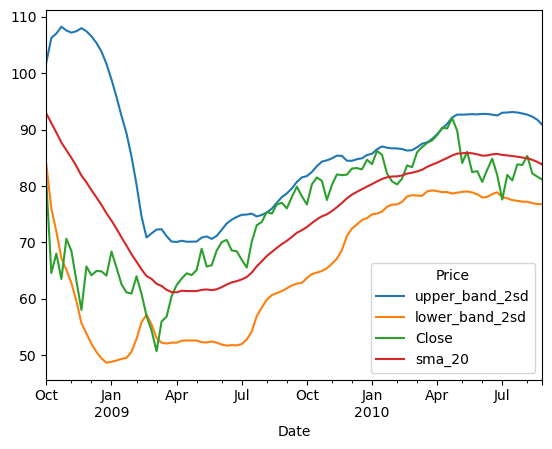

In [178]:
bollinger_train_data[['upper_band_2sd','lower_band_2sd','Close','sma_20']][100:200].plot()


In [179]:
# a = [2,4,5,4]
# pd.to_frame(a)

In [180]:
#Signal Generate
def generate_signal_bollinger(
    old_df:pd.DataFrame
) -> pd.DataFrame:
    df = old_df.copy()

    df['prev_close'] = \
        (
            df['Close']
            .shift(1)
        )
    
    signal = 0
    lst_signal = []
    for index, item in enumerate(df['Close']):
        if signal == 0:
            if (df['prev_close'].iloc[index] < df['Close'].iloc[index]) & (df['Close'].iloc[index] < df['lower_band_2sd'].iloc[index]):
                signal = 1
            if (df['prev_close'].iloc[index] > df['Close'].iloc[index]) & (df['Close'].iloc[index] > df['upper_band_2sd'].iloc[index]):
                signal =-1
        
        if signal ==-1:
            if df['Close'].iloc[index] < df['lower_band_2sd'].iloc[index]:
                signal = 1
            if df['Close'].iloc[index] < df['sma_20'].iloc[index]:
                signal = 0
        
        if signal == 1:
            if df['Close'].iloc[index] > df['upper_band_2sd'].iloc[index]:
                signal =-1
            if df['Close'].iloc[index] > df['sma_20'].iloc[index]:
                signal = 0
        lst_signal.append(signal)
    
    df['signals'] = \
        (
            lst_signal
        )
    df['position'] = \
        (
            df['signals']
            .shift(1)
            .fillna(0)
        )
    return df

In [181]:
bollinger_train_data = \
(
    generate_signal_bollinger(bollinger_train_data)
)

In [182]:
def compute_returns(
    old_df: pd.DataFrame
) -> pd.DataFrame:
    df = old_df.copy()

    df['daily_return'] = \
        (
            df['Close']
            .pct_change()
        )   

- Prof's momentum strat
- Range breakout momentum

## (1C) Machine Learning

In [183]:
stock_ticker = ["META", "AMZN", "AAPL", "NFLX", "GOOG", "SPY"]
forex_ticker = ["DEXUSEU", "DEXJPUS", "DEXUSUK", "DEXSZUS", "DEXCAUS", "DEXUSAL", "DEXUSNZ", "DEXNOUS", "DEXSDUS"]
index_ticker = ["DX-Y.NYB","GC=F", "CL=F", "HG=F", "^VIX"]
yield_ticker = ["^IRX", "^FVX", "^TNX"]

In [184]:
### download data
stock_data =\
(
    download_data(stock_ticker,
                  close_only = True)
)

forex_data =\
(
    pdr
    .get_data_fred(forex_ticker,
                  stock_data.index[0],
                  stock_data.index[-1])
)

index_data =\
(
    download_data(index_ticker,
                  close_only = True)
)

yield_data =\
(
    download_data(yield_ticker,
                  close_only = True)
)

C:\Users\TanFamily4\AppData\Local\Temp\ipykernel_2260\1882972918.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf.download(tickers = ticker,
[*********************100%***********************]  6 of 6 completed
C:\Users\TanFamily4\AppData\Local\Temp\ipykernel_2260\1882972918.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf.download(tickers = ticker,
[*********************100%***********************]  5 of 5 completed
C:\Users\TanFamily4\AppData\Local\Temp\ipykernel_2260\1882972918.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf.download(tickers = ticker,
[*********************100%***********************]  3 of 3 completed


In [186]:
index_data = index_data.where(index_data > 0)
index_data = index_data.ffill()

In [187]:
# technical indicators
technical_data1 = {}
technical_data2 = {}
target_data =\
(
    stock_data.loc[: , "SPY"]
    .copy()
)

In [188]:
sma_periods = [5, 10, 21, 50, 63, 100, 200, 252, 500]
ema_periods = [5, 10, 21, 50, 63, 100, 200, 252, 500]
rsi_periods = [2, 5, 7, 10, 14, 21, 28]
ROC_periods = [5, 10, 21, 50, 63, 126, 200, 252]        
MOM_periods = [5, 10, 21, 50, 63, 126, 200, 252]         
stochastic_periods = [5, 10, 14, 21]
return_period = 5    

In [189]:
# sma
for i in sma_periods:
    technical_data1[f"{i}_SMA"] =\
    (
        target_data
        .rolling(window = i)
        .mean()
    )

    # ema
for i in ema_periods:
    technical_data1[f"{i}_EMA"] =\
    (
        target_data
        .ewm(span = i)
        .mean()
    )

# rsi
def RSI(data, period):
    price_diff =\
    (
        data
        .diff()
        .dropna()
    )

    up = price_diff * 0
    down = up.copy()

    up[price_diff > 0] = price_diff[price_diff > 0]
    down[price_diff < 0] = -price_diff[price_diff < 0]

    up[up.index[period - 1]] = np.mean( up[ :period])
    up = up.drop(up.index[ :(period - 1)]
                )
    down[down.index[period - 1]] = np.mean( down[ :period])
    down = down.drop(down.index[ :(period - 1)]
                    )

    rs =\
    (
        up.ewm(com = period - 1,
               adjust = False).mean()
        /
        down.ewm(com = period - 1,
                 adjust = False).mean()
    )

    return 100 - 100 / (1 + rs)
    
for i in rsi_periods:
    technical_data2[f"{i}_RSI"] = RSI(target_data, i)

# RoC
def ROC(data, period):
    M = data.diff(period - 1)
    N = data.shift(period - 1)
    ROC = (M / N) * 100

    return ROC

for i in ROC_periods:
    technical_data2[f"{i}_ROC"] = ROC(target_data, i)   

# Price momentum
def MOM(data, periods):
    MOM = data.diff(periods)
    return MOM
for i in MOM_periods:
    technical_data2[f"{i}_MOM"] = MOM(target_data, i)

# Stochastic Oscillator data
stochastic_oscillator_data =\
(
    yf
    .download("SPY",
              start_date,
              end_date)
    [["Close", "Low", "High"]]
)

stochastic_oscillator_data.columns =\
(
    stochastic_oscillator_data
    .columns
    .droplevel(1)
)

# Stochastic Oscillator
def STOK(df = stochastic_oscillator_data
         , period = 1):
    STOK =\
    (
        ((df["Close"] - df["Low"].rolling(period).min())
        /
        (df["High"].rolling(period).max() - df["Low"].rolling(period).min())
        ) * 100
    )

    return STOK

def STOD(df = stochastic_oscillator_data
         , period = 1):
    STOK =\
    (
        ((df["Close"] - df["Low"].rolling(period).min())
        /
        (df["High"].rolling(period).max() - df["Low"].rolling(period).min())
        ) * 100
    )

    STOD = STOK.rolling(3).mean()
    return STOD

for i in stochastic_periods:
        technical_data2[f"{i}_%K"] = STOK(period = i)
        technical_data2[f"{i}_%D"] = STOD(period = i) 

C:\Users\TanFamily4\AppData\Local\Temp\ipykernel_2260\3839153180.py:77: FutureWarning: YF.download() has changed argument auto_adjust default to True
  .download("SPY",
[*********************100%***********************]  1 of 1 completed


In [190]:
# convert to df    
technical_data1 =\
(
    pd
    .DataFrame(technical_data1)
)

technical_data2 =\
(
    pd
    .DataFrame(technical_data2)
)

In [191]:
# setting of variables
Y =\
(
    np
    .log(stock_data.loc[ : , "SPY"]
        )
    .diff(return_period)
    .shift(-return_period)
)

Y.name =\
(
    Y
    .name
    +
    "_pred"
)

In [192]:
X1 =\
(
    np
    .log(stock_data.loc[ : , ("META", "AMZN", "AAPL", "NFLX", "GOOG")]
        )
    .diff(return_period)   
)

X2 =\
(
    np
    .log(forex_data)
    .diff(return_period)
)

X3 =\
(
    np
    .log(index_data)
    .diff(return_period)
)

X4 =\
(
    yield_data
    .diff(return_period)
    * 100
)

X5 =\
pd.concat(
    [np
     .log(stock_data.loc[ : , "SPY"]
         )
     .diff(i) for i in [return_period,
                        return_period * 3, # 15
                        return_period * 6, # 30
                        return_period * 12 # 60
                       ]
    ],
    axis = 1
).dropna()
X5.columns = ["SPY_DT", "SPY_3DT", "SPY_6DT", "SPY_12DT"]


X6 =\
(
    np
    .log(technical_data1)
    .diff(return_period)
)

X7 =\
(
    technical_data2
    .diff(return_period)
)



In [193]:
X =\
(
    pd
    .concat([X1, X2, X3, X4, X5, X6],
           axis =1)
)

X

,META,AMZN,AAPL,NFLX,GOOG,DEXUSEU,DEXJPUS,DEXUSUK,DEXSZUS,DEXCAUS,...,500_SMA,5_EMA,10_EMA,21_EMA,50_EMA,63_EMA,100_EMA,200_EMA,252_EMA,500_EMA
2006-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-06,-0.073987,0.086682,-0.006024,0.007338,0.012129,-0.002164,-0.007814,-0.003047,0.006091,0.010317,...,0.004551,-0.007866,-0.001084,0.002845,0.004648,0.004949,0.005241,0.004855,0.004650,0.004112
2025-11-07,-0.041957,0.000778,-0.007052,-0.013678,-0.007551,0.003201,-0.006447,0.001825,0.001618,0.004629,...,0.004496,-0.010702,-0.003865,0.001088,0.003806,0.004263,0.004791,0.004624,0.004465,0.004014
2025-11-10,-0.009374,-0.022294,0.002380,0.017999,0.022517,0.001213,-0.000909,0.000532,-0.001363,-0.001425,...,0.004464,-0.008052,-0.003667,0.000732,0.003540,0.004035,0.004633,0.004543,0.004400,0.003981
2025-11-11,-0.000383,-0.000883,0.020079,0.039011,0.048026,NaN,NaN,NaN,NaN,NaN,...,0.004473,-0.001561,-0.000919,0.001711,0.003856,0.004273,0.004774,0.004618,0.004462,0.004017


In [194]:
data =\
(
    pd
    .concat([Y, X],
           axis = 1)
    .dropna()
)

data =\
(
    data
    .iloc[ : :return_period, : ]
)

In [195]:
Y =\
(
    data
    .loc[ : ,Y.name]
)

X =\
(
    data
    .loc[ : , X.columns]
)

In [196]:
testing_set = 0.25

train_size = int(len(X) * (1 - testing_set))

Y_train, Y_test =\
(
    Y[0 : train_size],
    Y[train_size:len(Y)]
)

X_train, X_test =\
(
    X[0: train_size],
    X[train_size:len(X)]
)

In [197]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [198]:
X_train_scaled =\
    (
        pd
        .DataFrame(
            scaler.transform(X_train),
            index = X_train.index,
            columns = X_train.columns
        )
    )

X_test_scaled =\
    (
        pd
        .DataFrame(
            scaler.transform(X_test),
            index = X_test.index,
            columns = X_test.columns
        )
    )

In [199]:
models =\
[
    ("LR", LinearRegression()),
    ("Elastic Net Penalty", ElasticNet()),
    ("LASSO", Lasso()),
    ("Support Vector Machine", SVR()),
    ("K-Nearest Neighbors", KNeighborsRegressor()),
    ("Decision Tree", DecisionTreeRegressor()),
    ("Extra Trees Algo", ExtraTreesRegressor()),
    ("Random Forest", RandomForestRegressor()),
    ("Gradient Boosting", GradientBoostingRegressor()),
    ("Adaptive Boosting", AdaBoostRegressor())
]

In [200]:
names = []

train_results = []
test_results = []

kfold_results = []

best_models = {}
ml_equity_curves = {}
results = []
ncomps_list = [5, 10 ,15, 20, 25, 30, 35, 40]

In [201]:
seed = 627
num_folds = 10
ncomps = 30
metric = "neg_mean_squared_error"

Variance preserved by first 30 components == 99.18%


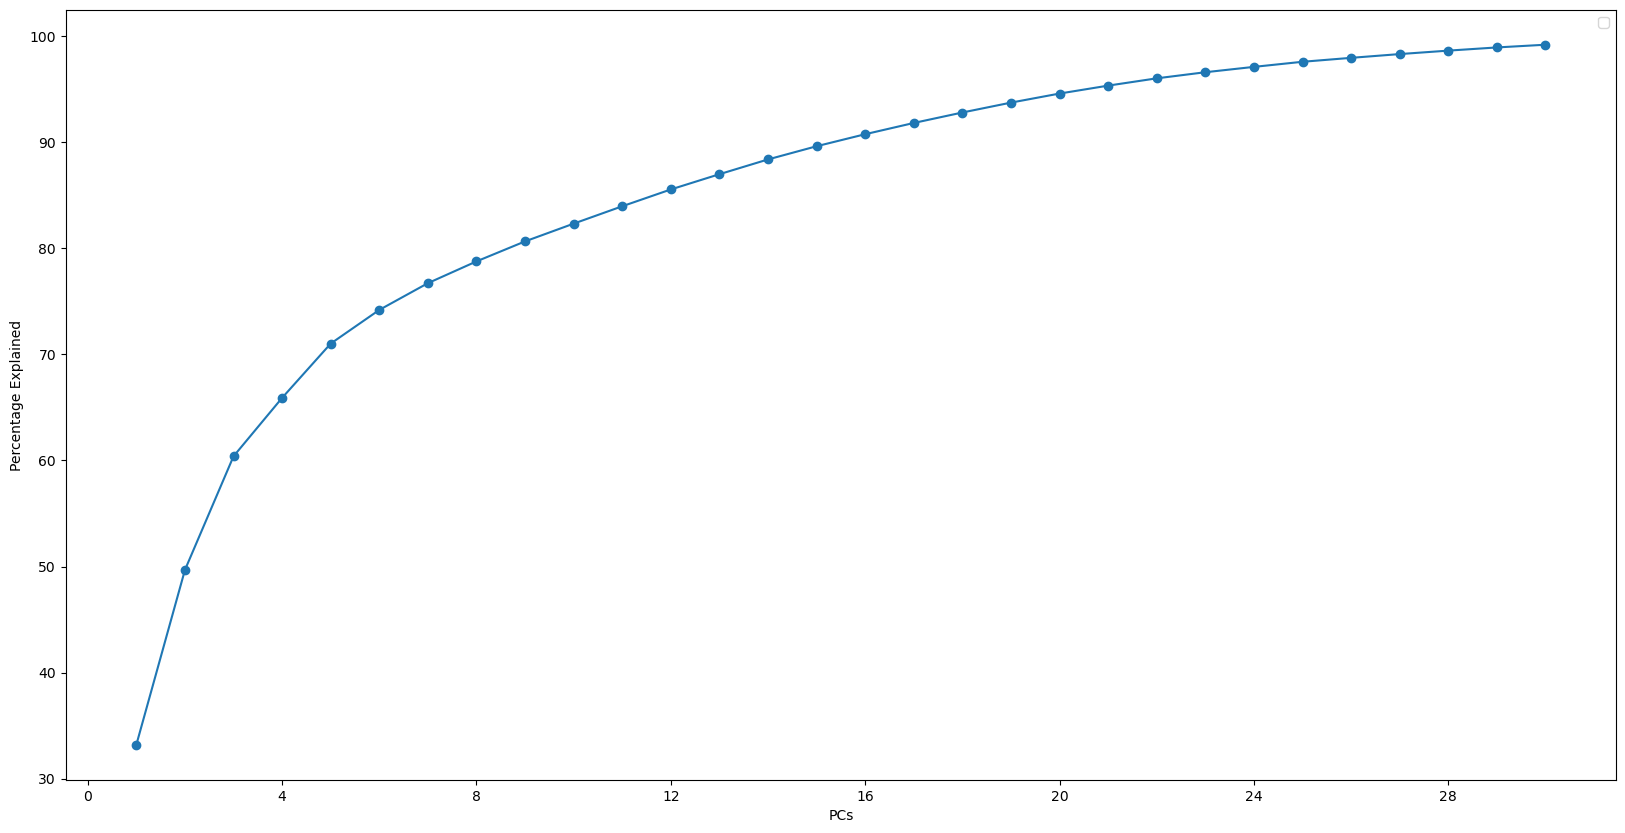

In [202]:
svd_for_plot = TruncatedSVD(n_components=ncomps, random_state=seed)
svd_for_plot.fit(X_train_scaled)

plt_data = pd.DataFrame(
    svd_for_plot.explained_variance_ratio_.cumsum() * 100,
    index=np.arange(1, ncomps + 1),
    columns=["cum_var_explained"]
)

ax = plt_data.plot(kind="line", figsize=(20, 10), style="o-")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("PCs")
ax.set_ylabel("Percentage Explained")
ax.legend("")

print(
    "Variance preserved by first {} components == {:.2%}".format(
        ncomps,
        svd_for_plot.explained_variance_ratio_.cumsum()[-1]
    )
)

In [203]:
param_grids =\
{
    "LR":\
    {
        "model__fit_intercept": [True, False]
    },

    "Elastic Net Penalty":\
    {
        "model__alpha": np.logspace(-4, 2, 7),
        "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
        "model__max_iter": [5000]
    },

    "LASSO":\
    {
        "model__alpha": np.logspace(-5, 1, 7),
        "model__max_iter": [5000]
    },

    "Support Vector Machine":\
    {
        "model__C": [0.1, 1, 10],
        "model__gamma": ["scale", "auto"],
        "model__epsilon": [0.001, 0.01, 0.1],
        "model__kernel": ["rbf"]
    },

    "K-Nearest Neighbors":\
    {
        "model__n_neighbors": [3, 5, 9, 15],
        "model__weights": ["uniform", "distance"]
    },

    "Decision Tree":\
    {
        "model__max_depth": [3, 5, 10, None],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4]
    },

    "Extra Trees Algo":\
    {
        "model__n_estimators": [100, 300],
        "model__max_depth": [None, 10],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4],
        "model__max_features": ["sqrt", None]
    },

    "Random Forest":\
    {
        "model__n_estimators": [150, 300],
        "model__max_depth": [None, 10],
        "model__min_samples_split": [2, 10],
        "model__min_samples_leaf": [1, 2],
        "model__max_features": ["sqrt", None]
    },

    "Gradient Boosting":\
    {
        "model__n_estimators": [100, 200],
        "model__learning_rate": [0.05, 0.1],
        "model__max_depth": [2, 3],
        "model__subsample": [0.6, 0.8],
        "model__min_samples_split": [2],
        "model__min_samples_leaf": [1, 2]
    },

    "Adaptive Boosting":\
    {
        "model__n_estimators": [50, 150],
        "model__learning_rate": [0.05, 0.5],
        "model__loss": ["linear", "square"]
    }
}


In [204]:
def calculate_ml_results(y_true,
                        y_pred,
                        return_period = return_period,
                        initial_capital = 1e5
                        ):
    data =\
    (
        pd
        .concat(
            [y_true.rename("y_true"),
             y_pred.rename("y_pred")],
             axis = 1
        )
        .dropna()
    )

    signal =\
    (
        np
        .sign(data["y_pred"])   
    )

    position =\
    (
        signal
        .shift(1)
        .fillna(0)
    )

    strategy_returns =\
    (
        position
        *
        data["y_true"]
    )

    equity_curve =\
    (
        np
        .exp(strategy_returns.cumsum())
        *
        initial_capital
    )

    periods_per_year =\
    (
        252
        /
        return_period
    )

    mean_return =\
    (
        strategy_returns
        .mean()
    )

    std_return =\
    (
        strategy_returns
        .std()
    )

    sharpe =\
    (
        mean_return
        /
        std_return
        *
        np.sqrt(periods_per_year)
    )

    n_periods = strategy_returns.shape[0]
    years = n_periods / periods_per_year

    final_equity = equity_curve.iloc[-1]

    cagr =\
    (
        (final_equity / initial_capital) ** (1/ years)
        - 1
    )

    running_max =\
    (
        equity_curve
        .cummax()
    )

    drawdown =\
    (
        equity_curve
        /
        running_max
        - 1
    )

    max_drawdown = drawdown.min()
    
    results =\
    {
        "sharpe": sharpe,
        "cagr": cagr,
        "max_drawdown": max_drawdown,
        "final_equity": final_equity,
        "equity_curve": equity_curve
    }

    return results

In [205]:
for ncomps in ncomps_list:
    print(f"\n===== Running models for ncomps = {ncomps} =====")

    for name, model in models:

        names.append(f"{name}_nc{ncomps}")

        kfold =\
        (
            KFold(n_splits = num_folds,
                random_state = seed,
                shuffle = True)
        )

        # run SVD
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("svd", TruncatedSVD(n_components = ncomps, random_state = seed)),
            ("model", model)
        ])

        param_grid = param_grids.get(name, {})

        grid_search =\
        (
            GridSearchCV(estimator = pipe,
                        param_grid = param_grid,
                        cv = kfold,
                        scoring = metric,
                        n_jobs = -1)
        )

        grid_search.fit(X_train, Y_train)

        res = grid_search.best_estimator_
        best_models[(name, ncomps)] = res
        best_index = grid_search.best_index_

        cv_scores =\
        (
            np
            .array(
                [grid_search.cv_results_[f"split{i}_test_score"][best_index]
                for i in range(num_folds)]
            )
        )
        
        cv_scores = -1 * cv_scores

        kfold_results.append(cv_scores)

        train_result = mean_squared_error(res.predict(X_train), Y_train)
        train_results.append(train_result)

        # Assess the performance in Testing Set

        test_result = mean_squared_error(res.predict(X_test), Y_test)
        test_results.append(test_result)

        y_pred_test =\
        (
            pd
            .Series(res.predict(X_test),
                    index = Y_test.index,
                    name = f"{name}_nc{ncomps}_pred"
                    )
        )

        bt_results =\
        (
            calculate_ml_results(y_true = Y_test,
                                y_pred = y_pred_test)
        )
        
        ml_equity_curves[(name, ncomps)] = bt_results["equity_curve"]

        results.append(
            {
                "Model": name,
                "ncomps": ncomps,
                "CV_MSE_mean": cv_scores.mean(),
                "CV_MSE_std":  cv_scores.std(),
                "Train_MSE":   train_result,
                "Test_MSE":    test_result,
                "Sharpe":      bt_results["sharpe"],
                "CAGR":        bt_results["cagr"],
                "Max_Drawdown":bt_results["max_drawdown"],
                "Final_Equity":bt_results["final_equity"],
                "Best_Params": grid_search.best_params_
            }
        )
        user_interface_message = "%s: %f (%f) %f %f Sharpe=%f CAGR=%f MDD=%f Final=%f" %\
        (
            name, 
            cv_scores.mean(), 
            cv_scores.std(), 
            train_result, 
            test_result,
            bt_results["sharpe"],
            bt_results["cagr"],
            bt_results["max_drawdown"],
            bt_results["final_equity"]
        )
        print(user_interface_message)


===== Running models for ncomps = 5 =====
LR: 0.000438 (0.000136) 0.000412 0.000505 Sharpe=1.101405 CAGR=0.193915 MDD=-0.182456 Final=176151.691123
Elastic Net Penalty: 0.000419 (0.000119) 0.000417 0.000514 Sharpe=1.093836 CAGR=0.192495 MDD=-0.182456 Final=175483.553745
LASSO: 0.000419 (0.000119) 0.000417 0.000514 Sharpe=1.093836 CAGR=0.192495 MDD=-0.182456 Final=175483.553745
Support Vector Machine: 0.000450 (0.000111) 0.000255 0.000594 Sharpe=1.151827 CAGR=0.203395 MDD=-0.182456 Final=180658.782105
K-Nearest Neighbors: 0.000440 (0.000124) 0.000000 0.000549 Sharpe=1.445046 CAGR=0.259327 MDD=-0.136715 Final=208875.370273
Decision Tree: 0.000443 (0.000095) 0.000362 0.000611 Sharpe=1.226708 CAGR=0.217552 MDD=-0.190721 Final=187536.193893
Extra Trees Algo: 0.000418 (0.000120) 0.000351 0.000513 Sharpe=0.986579 CAGR=0.172493 MDD=-0.182456 Final=166252.642632
Random Forest: 0.000432 (0.000105) 0.000214 0.000580 Sharpe=0.795258 CAGR=0.137352 MDD=-0.190721 Final=150852.752428
Gradient Boostin

In [206]:
results_df =\
(
    pd
    .DataFrame(results)
    .set_index(["Model", "ncomps"])
).sort_values(by = "Final_Equity",
              ascending = False)

results_df


,,CV_MSE_mean,CV_MSE_std,Train_MSE,Test_MSE,Sharpe,CAGR,Max_Drawdown,Final_Equity,Best_Params
Model,ncomps,,,,,,,,,
K-Nearest Neighbors,5,0.000440,0.000124,0.000000e+00,0.000549,1.445046,0.259327,-0.136715,208875.370273,"{'model__n_neighbors': 15, 'model__weights': '..."
Extra Trees Algo,20,0.000412,0.000113,2.329652e-04,0.000545,1.347349,0.240548,-0.190721,199087.064361,"{'model__max_depth': 10, 'model__max_features'..."
K-Nearest Neighbors,25,0.000437,0.000125,2.496903e-17,0.000551,1.331592,0.237532,-0.182456,197544.995068,"{'model__n_neighbors': 15, 'model__weights': '..."
Adaptive Boosting,15,0.000420,0.000123,3.567170e-04,0.000515,1.315894,0.234531,-0.190721,196018.783633,"{'model__learning_rate': 0.05, 'model__loss': ..."
Decision Tree,5,0.000443,0.000095,3.620208e-04,0.000611,1.226708,0.217552,-0.190721,187536.193893,"{'model__max_depth': 3, 'model__min_samples_le..."
...,...,...,...,...,...,...,...,...,...,...
Gradient Boosting,40,0.000447,0.000140,1.515061e-04,0.000671,0.199653,0.033036,-0.214645,110940.684456,"{'model__learning_rate': 0.1, 'model__max_dept..."
Adaptive Boosting,30,0.000417,0.000134,3.230096e-04,0.000515,0.049908,0.008161,-0.200606,102630.325777,"{'model__learning_rate': 0.05, 'model__loss': ..."
Support Vector Machine,15,0.000465,0.000117,8.768433e-05,0.000570,0.035274,0.005761,-0.298210,101851.981762,"{'model__C': 0.1, 'model__epsilon': 0.01, 'mod..."


In [207]:
from lets_plot import *
LetsPlot.setup_html()

In [208]:
df_for_plot =\
(
    pd
    .DataFrame(
        {"Algorithms": names * 2,
         "Data": ["Training Set"] * len(names) + ["Testing Set"] * len(names),
         "Performance": train_results + test_results
        }
    )
)


In [209]:
for (name, ncomps),  fitted_pipe in best_models.items():
    print(f"\n=== Fitting and plotting for model: {name} ===")

    # predict on test set
    y_predictions = fitted_pipe.predict(X_test)

    # Convert predictions to Series aligned with Y_test index
    y_predictions = pd.Series(
        data=y_predictions,
        index=Y_test.index,
        name=f"{name} Predictions"
    )

    # Build cumulative return curves
    actual_results = np.exp(Y_test).cumprod()
    pred_results   = np.exp(y_predictions).cumprod()

    difference = actual_results - pred_results

    # Build DataFrame for plotting
    df_outcome = pd.DataFrame(
        {
            "date": actual_results.index,
            "future SPY": actual_results.values,
            "predicted SPY": pred_results.values,
            "difference": difference.values
        }
    )

    # Long format for lets-plot
    df_outcome_ggplot = df_outcome.melt(
        id_vars=["date", "difference"],
        var_name="series",
        value_name="value"
    )

    # Dynamic y-limit so plots scale nicely
    y_max = float(df_outcome_ggplot["value"].max() * 1.1)

    # Plot using lets-plot
    p = \
    (
        ggplot(df_outcome_ggplot, aes(x="date", y="value", color="series"))
        + geom_line()
        + geom_point()
        + scale_y_continuous(limits=[0, y_max])
        + scale_color_manual(
            values={
                "future SPY": "blue",
                "predicted SPY": "red"
            }
        )
        + ggtitle(f"Predicting SPY Cumulative Returns with {name}")
        + xlab("Date")
        + ylab("Cumulative Returns")
        + theme(legend_position="top")
        + ggsize(1000, 500)
    )

    # show plot for this model
    p.show()



=== Fitting and plotting for model: LR ===



=== Fitting and plotting for model: Elastic Net Penalty ===



=== Fitting and plotting for model: LASSO ===



=== Fitting and plotting for model: Support Vector Machine ===



=== Fitting and plotting for model: K-Nearest Neighbors ===



=== Fitting and plotting for model: Decision Tree ===



=== Fitting and plotting for model: Extra Trees Algo ===



=== Fitting and plotting for model: Random Forest ===



=== Fitting and plotting for model: Gradient Boosting ===



=== Fitting and plotting for model: Adaptive Boosting ===



=== Fitting and plotting for model: LR ===



=== Fitting and plotting for model: Elastic Net Penalty ===



=== Fitting and plotting for model: LASSO ===



=== Fitting and plotting for model: Support Vector Machine ===



=== Fitting and plotting for model: K-Nearest Neighbors ===



=== Fitting and plotting for model: Decision Tree ===



=== Fitting and plotting for model: Extra Trees Algo ===



=== Fitting and plotting for model: Random Forest ===



=== Fitting and plotting for model: Gradient Boosting ===



=== Fitting and plotting for model: Adaptive Boosting ===



=== Fitting and plotting for model: LR ===



=== Fitting and plotting for model: Elastic Net Penalty ===



=== Fitting and plotting for model: LASSO ===



=== Fitting and plotting for model: Support Vector Machine ===



=== Fitting and plotting for model: K-Nearest Neighbors ===



=== Fitting and plotting for model: Decision Tree ===



=== Fitting and plotting for model: Extra Trees Algo ===



=== Fitting and plotting for model: Random Forest ===



=== Fitting and plotting for model: Gradient Boosting ===



=== Fitting and plotting for model: Adaptive Boosting ===



=== Fitting and plotting for model: LR ===



=== Fitting and plotting for model: Elastic Net Penalty ===



=== Fitting and plotting for model: LASSO ===



=== Fitting and plotting for model: Support Vector Machine ===



=== Fitting and plotting for model: K-Nearest Neighbors ===



=== Fitting and plotting for model: Decision Tree ===



=== Fitting and plotting for model: Extra Trees Algo ===



=== Fitting and plotting for model: Random Forest ===



=== Fitting and plotting for model: Gradient Boosting ===



=== Fitting and plotting for model: Adaptive Boosting ===



=== Fitting and plotting for model: LR ===



=== Fitting and plotting for model: Elastic Net Penalty ===



=== Fitting and plotting for model: LASSO ===



=== Fitting and plotting for model: Support Vector Machine ===



=== Fitting and plotting for model: K-Nearest Neighbors ===



=== Fitting and plotting for model: Decision Tree ===



=== Fitting and plotting for model: Extra Trees Algo ===



=== Fitting and plotting for model: Random Forest ===



=== Fitting and plotting for model: Gradient Boosting ===



=== Fitting and plotting for model: Adaptive Boosting ===



=== Fitting and plotting for model: LR ===



=== Fitting and plotting for model: Elastic Net Penalty ===



=== Fitting and plotting for model: LASSO ===



=== Fitting and plotting for model: Support Vector Machine ===



=== Fitting and plotting for model: K-Nearest Neighbors ===



=== Fitting and plotting for model: Decision Tree ===



=== Fitting and plotting for model: Extra Trees Algo ===



=== Fitting and plotting for model: Random Forest ===



=== Fitting and plotting for model: Gradient Boosting ===



=== Fitting and plotting for model: Adaptive Boosting ===



=== Fitting and plotting for model: LR ===



=== Fitting and plotting for model: Elastic Net Penalty ===



=== Fitting and plotting for model: LASSO ===



=== Fitting and plotting for model: Support Vector Machine ===



=== Fitting and plotting for model: K-Nearest Neighbors ===



=== Fitting and plotting for model: Decision Tree ===



=== Fitting and plotting for model: Extra Trees Algo ===



=== Fitting and plotting for model: Random Forest ===



=== Fitting and plotting for model: Gradient Boosting ===



=== Fitting and plotting for model: Adaptive Boosting ===



=== Fitting and plotting for model: LR ===



=== Fitting and plotting for model: Elastic Net Penalty ===



=== Fitting and plotting for model: LASSO ===



=== Fitting and plotting for model: Support Vector Machine ===



=== Fitting and plotting for model: K-Nearest Neighbors ===



=== Fitting and plotting for model: Decision Tree ===



=== Fitting and plotting for model: Extra Trees Algo ===



=== Fitting and plotting for model: Random Forest ===



=== Fitting and plotting for model: Gradient Boosting ===



=== Fitting and plotting for model: Adaptive Boosting ===


In [210]:
bh_pred = pd.Series(
    data = 1.0,
    index = Y_test.index,
    name = "buy_and_hold_pred"
)

bh_results = calculate_ml_results(
    y_true = Y_test,
    y_pred = bh_pred,        
    return_period = return_period,
    initial_capital = 1e5    
)

bh_sharpe = bh_results["sharpe"]
bh_cagr = bh_results["cagr"]
bh_mdd = bh_results["max_drawdown"]
bh_final_equity = bh_results["final_equity"]
bh_equity_curve = bh_results["equity_curve"]

print("Buy & Hold SPY (test period)")
print(f"Sharpe:{bh_sharpe:.3f}")
print(f"CAGR:{bh_cagr:.3%}")
print(f"Max Drawdown:{bh_mdd:.2%}")
print(f"Final Balance:{bh_final_equity:,.2f}")

Buy & Hold SPY (test period)
Sharpe:1.094
CAGR:19.250%
Max Drawdown:-18.25%
Final Balance:175,483.55


In [211]:
strategy_name = "Gradient Boosting"
strategy_ncomps = 10

strategy_equity = ml_equity_curves[(strategy_name, strategy_ncomps)]
bh_equity = bh_equity_curve   

df_plot = pd.DataFrame({
    "date": strategy_equity.index,
    "Strategy": strategy_equity.values,
    "Buy_and_Hold": bh_equity.reindex(strategy_equity.index).values
})

df_long = df_plot.melt(
    id_vars="date",
    var_name="series",
    value_name="equity"
)

p =\
(
    ggplot(df_long, aes(x="date", y="equity", color="series"))
    + geom_line()
    + ggtitle(f"Equity Curve: {strategy_name} (ncomps={strategy_ncomps}) vs Buy & Hold SPY")
    + xlab("Date")
    + ylab("Portfolio Value")
    + theme(legend_position="top")
    + ggsize(1000, 500)
)

p.show()

In [212]:
# Strategy data
row = results_df.loc[(strategy_name, strategy_ncomps)]
st_sharpe = row["Sharpe"]
st_cagr = row["CAGR"]
st_mdd = row["Max_Drawdown"]
st_final_equity = row["Final_Equity"]

# Compute differences (strategy minus buy & hold)
sharpe_diff = st_sharpe - bh_sharpe
cagr_diff_pct = (st_cagr - bh_cagr) * 100 
mdd_diff_pct = (st_mdd - bh_mdd)  * 100
final_equity_diff = st_final_equity - bh_final_equity

print(f"=== Strategy vs Buy & Hold (Test Period) ===")
print(f"Sharpe (Strategy):{st_sharpe:.3f}")
print(f"Sharpe (Buy & Hold):{bh_sharpe:.3f}")
print(f"Sharpe Difference:{sharpe_diff:+.3f}")

print()
print(f"CAGR (Strategy):{st_cagr*100:6.2f}%.")
print(f"CAGR (Buy & Hold):{bh_cagr*100:6.2f}%.")
print(f"CAGR Difference:{cagr_diff_pct:+6.2f}%.")

print()
print(f"Max Drawdown (Strategy):{st_mdd*100:6.2f}%")
print(f"Max Drawdown (B&H):{bh_mdd*100:6.2f}%")
print(f"MDD Difference:{mdd_diff_pct:+6.2f}% ")

print()
print(f"Final Equity (Strategy):{st_final_equity:,.2f}")
print(f"Final Equity (B&H):{bh_final_equity:,.2f}")
print(f"Final Equity Difference:+${final_equity_diff:,.2f}")

=== Strategy vs Buy & Hold (Test Period) ===
Sharpe (Strategy):0.816
Sharpe (Buy & Hold):1.094
Sharpe Difference:-0.277

CAGR (Strategy): 14.12%.
CAGR (Buy & Hold): 19.25%.
CAGR Difference: -5.13%.

Max Drawdown (Strategy):-15.81%
Max Drawdown (B&H):-18.25%
MDD Difference: +2.44% 

Final Equity (Strategy):152,484.63
Final Equity (B&H):175,483.55
Final Equity Difference:+$-22,998.92


# Part 2: Visualisations and Comparisons

**The 3 Strategies**

1. Momentum Trading Strategy: Moving Average

2. 

3. Gradient Boosting Strategy

# Part 3. Executive Summary of Trading Strategies and Backtesting Results

## The 3 Strategies

**The 3 Strategies employed** includes one from each category, with the results compared against the benchmark return from the periods of `11 February 2021` to `12 November 2025`

_Strategy A: (Momentum Trading)_ 


_Strategy B: (Mean-Reversion)_


_Strategy C: (Machine Learning) - Gradient Boosting_



<font size = 4.5>_**Metrics Generated**_</font>

**1. Sharpe Ratio** <br />
Measures risk-adjusted return by scaling the average return by its volatility. A higher Sharpe Ratio indicates that a strategy generates more return per unit of risk.

**2. Compound Annual Growth Rate (CAGR)** <br />
Summarises the long-run growth rate of the portfolio. It captures how quickly wealth compounds over the full sample period.

**3. Maximum and Longest Drawdown (MDD)** <br />
Quantifies the worst peak-to-trough loss experienced by the strategy. This is a key indicator of downside risk and how long the portfolio experiences drawdown, which is not a rational investor with a degree of risk aversion would like to see.


## Strategy A

Strategy A is built on the idea that returns tend to exhibit persistence: strong recent performance can be followed by further gains, while recent weakness can be followed by additional losses. In practice, we construct a momentum signal using past S&P 500 returns over a fixed lookback window. When the recent cumulative return is sufficiently positive, the strategy takes or increases a long position; when the recent cumulative return is sufficiently negative, the strategy either reduces risk or, depending on the rule specification, may take a short position.

The economic intuition is that momentum benefits from extended trending regimes: prolonged bull markets or deep bear markets in which price moves in one direction for some time. Conversely, the strategy is vulnerable to sideways markets with frequent reversals, where trend signals whipsaw and turnover increases.

**Summary of Results**

Portfolio       |   Strategy A      |   Benchmark   |
--              |   --              |      --       |
Sharpe          |   1.58            |   1.09        |
CAGR            |   28.55%          |  19.25%       |
Max Drawdown    | -13.02%           |   -18.25%     |
Final Value     |   $223,071.91     | $175,483.65   |

It can be seen that strategy A is almost an exact similar returns. This is because the momentum strategy reflected the economic environment where the SPY continued an upward momentum.

The results show that the strategy effective followed the benchmark return and maintained exposure throughout the test period, converging to a buy-and-hold strategy. Additionally, the use of weekly data up to a short MA of <mark>40 weeks (~1 year)</mark> meant that the moving average would move more meaningfully in the longer term.

## Strategy B

Strategy B takes a contrarian view - instead of betting on trends, it assumes that prices tend to revert towards some “fair value” or medium-term equilibrium. This is operationalised by comparing the current S&P 500 level to a smoothed reference as a normalisation factor. In this case, the use of <mark>indicators insert here </mark>

A typical implementation uses a standardised price change relative to its rolling mean. When the index trades far below its standardised value (a negative z-score), the strategy interprets this as an oversold condition and increases long exposure. When the index trades far above its standardised value (a positive z-score), the strategy treats this as an overbought condition and reduces or even reverses the position.

The intuition is that mean-reversion strategies tend to perform better in choppy or range-bound markets, where deviations from the average are repeatedly corrected. 


**Summary of Results**

Portfolio       |   Strategy B      |   Benchmark   |
--              |   --              |      --       |
Sharpe          |   1.58            |   1.09        |
CAGR            |   28.55%          |  19.25%       |
Max Drawdown    | -13.02%           |   -18.25%     |
Final Value     |   $223,071.91     | $175,483.65   |

## Strategy C

Strategy C employs a supervised machine learning approach to predict the 5-day forward log returns of the SPY ETF. A panel of models was run using a pipeline of StandScaler and Truncated SVD with the respective hyper-parameter tuning for each model as well as a 10-fold cross-validation. The metric used for training the model was negative mean-squared error. The goal was to get the closest error to 0. The best tuned training models were then tested on a list of Truncated SVD values to see which number of components yielded the best results out-of-sample. The final results were sorted and the model with the best final equity was chosen.

The feature set comprised of:
- MAANG stocks (META, AMZN, AAPL, NFLX, GOOG) as they are large consitutents of the SPY and their moves can drive the overall direction of the index.
- G10 foreign exchange currencies (9 currency pairs) the movement of the currencies can show potential information about potential stock purchase flow as foreigners would have to sell their local currency and buy USD to buy US stocks.
- Commodities and volatility index (DXY, Gold, Crude Oil, Copper, VIX) as broad macro and risk-sentiment indicators to show dollar demand and risk off or risk-off attitudes. broad USD dynamics (DXY), inflation / safe-haven demand (Gold, Oil), global growth / China cycle (Copper, Oil), and overall risk-on / risk-off regimes (VIX).
- Treasury yields (3-month, 5-year, 10-year) to model the shape of the US risk-free curve and market's macro views on interest rate directions which has impact on the US economy and stock market. Also a proxy for monetary policy and the health of the economy. Steepening/flattening, which encodes recession risk vs expansion.
- Multiple lagged SPY returns (5, 15, 30, 60 days) as historical price is supposed to capture most data or information about itself. It reflects the state of the index across different tenors and market states.
- Technical indicators (SMA, EMA, ROC, MOM, RSI, STOK) which gives a compact and diverse summary of trend (SMA,EMA), speed and persistence of moves aka short-to-medium term momentum (ROC, MOM) and mean-reversion pressures seen in local stretch or overbought-oversold conditions (RSI, STOK).

The best model from the backtest led to the use of Gradient Boosting Regression with 10 components for Truncated SVD being employed as Strategy C.

**Summary of Results**:

Portfolio       |   Strategy C      |   Benchmark   |
--              |   --              |      --       |
Sharpe          |   1.58            |   1.09        |
CAGR            |   28.55%          |  19.25%       |
Max Drawdown    | -13.02%           |   -18.25%     |
Final Value     |   $223,071.91     | $175,483.65   |


Over the test period, Strategy C meaningfully outperforms a buy-and-hold SPY benchmark on both risk-adjusted and absolute returns, while also reducing drawdowns.

On a risk-adjusted basis, Strategy C delivers a Sharpe ratio of 1.58, compared with 1.09 for buy-and-hold. This improvement of about +0.49 in the Sharpe ratio shows that Strategy C generates noticeably more return per unit of risk than simply holding SPY.

In terms of growth, Strategy C achieves a CAGR of 28.55%, versus 19.25% for buy-and-hold, an outperformance of +9.30% per year over the test window. This translates into final equity of $223,071.91 for Strategy C versus $175,483.65 for buy-and-hold, i.e. roughly $47,588 more, or about 27% higher terminal wealth from the same starting capital.

From a risk / drawdown perspective, Strategy C also improves the path of returns. Its maximum drawdown is −13.02%, compared with −18.25% for buy-and-hold, a reduction of about 5.2% in peak-to-trough loss. This indicates that Strategy C not only delivers higher returns, but does so with a smoother equity curve and better downside protection than the benchmark.

# Part 4: Self-Critique

## 4.1 Engaging A 'Purist' Mindset

In this project, we attempted a first a purist approach to our strategies, focusing on standalone strategies for mean-reversion, momentum trading and machine learning approaches. In a more complex world that has embraced large sets of data and permitted higher frequency of trading, this means that such strategies would not be as profitable as expected. A more complex algorithm 

#### Ex-Post versus Ex-Ante
> "Our current backtest is largely an ex-post evaluation of the machine learning strategy. While it provides useful diagnostics, it does not fully capture how the model would have performed ex-ante, using only information available at each decision date. In particular, the extensive model and hyperparameter search across many specifications increases the risk that our ‘best’ model is chosen with the benefit of hindsight, rather than reflecting a truly ex-ante implementable process.”
Furthermore in reality, an ex-ante implementation would need a rules-based way to select features (e.g. largest stocks at each point in time, full index universe, or sector indices), rather than hard-coding today’s winners into the model."